# Fluidity Local: Stress Relaxation with Thixotropic Aging

**Learning Objectives:**
- Fit FluidityLocal to stress relaxation data from thixotropic yield-stress fluids
- Understand non-exponential relaxation driven by evolving fluidity f(t)
- Track accelerating relaxation from structural recovery (aging: f → f_eq)
- Compare FluidityLocal vs Maxwell-type exponential decay

**Prerequisites:** basic/01, bayesian/01, fluidity/01 (flow curve)

**Runtime:** Fast ~2 min (num_chains=1), Full ~5 min (num_chains=4)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os

    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

# Add examples/utils to path for tutorial utilities (robust path resolution)
# Works whether CWD is project root, examples/, or examples/fluidity/
import rheojax
_rheojax_root = os.path.dirname(os.path.dirname(rheojax.__file__))
_utils_path = os.path.join(_rheojax_root, "examples", "utils")
if os.path.exists(_utils_path) and _utils_path not in sys.path:
    sys.path.insert(0, _utils_path)

from fluidity_tutorial_utils import (
    generate_synthetic_relaxation,
    get_output_dir,
    print_convergence_summary,
    print_parameter_comparison,
    save_fluidity_results,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Fluidity Stress Relaxation

After a step strain γ₀ is imposed at t=0, the stress relaxes as:

$$\frac{d\sigma}{dt} = -G\sigma f(t), \quad \frac{df}{dt} = \frac{f_{eq} - f}{\theta}$$

where:
- **G**: Elastic modulus (Pa)
- **f(t)**: Time-dependent fluidity (1/(Pa·s))
- **f_eq**: Equilibrium fluidity at rest (1/(Pa·s))
- **θ**: Aging time scale (s)

**Key Behavior:**
1. **Initial fast decay**: f starts high (from prior flow), σ decays rapidly
2. **Aging slowdown**: f decreases toward f_eq as structure recovers
3. **Accelerating relaxation**: Lower f means slower stress relaxation → stretched exponential signature

**Contrast with Maxwell:** Standard viscoelastic models predict σ(t) = σ₀ exp(-t/τ) with constant relaxation time τ. Fluidity models exhibit **time-dependent relaxation** due to evolving microstructure.

**Thixotropic Signature:** The relaxation modulus G(t) = σ(t)/γ₀ decays faster at short times (high f, recent flow) and slower at long times (low f, structural recovery).

## 3. Load Data

We'll use synthetic data generated from a calibrated FluidityLocal model. In practice, you would load experimental relaxation data from laponite clays or other thixotropic materials.

In [4]:
# Generate synthetic relaxation data
# (In real workflow, load from clay data: load_clay_relaxation(aging_time=60))

# Create a reference model with thixotropic parameters
model_ref = FluidityLocal()
model_ref.parameters.set_value("G", 1000.0)  # Pa
model_ref.parameters.set_value("tau_y", 50.0)  # Pa
model_ref.parameters.set_value("K", 10.0)  # Pa·s^n
model_ref.parameters.set_value("n_flow", 0.5)  # dimensionless
model_ref.parameters.set_value("f_eq", 0.001)  # 1/(Pa·s)
model_ref.parameters.set_value("f_inf", 0.01)  # 1/(Pa·s)
model_ref.parameters.set_value("theta", 10.0)  # s
model_ref.parameters.set_value("a", 0.1)  # dimensionless
model_ref.parameters.set_value("n_rejuv", 1.0)  # dimensionless
model_ref.fitted_ = True

# Generate synthetic data
t_data, stress = generate_synthetic_relaxation(
    model_ref, sigma_0=500.0, t_end=100.0, n_points=80, noise_level=0.05, seed=42
)

print(f"Data: {len(t_data)} points, t=[{t_data.min():.3f}, {t_data.max():.1f}] s")
print(f"Stress range: [{stress.min():.1f}, {stress.max():.1f}] Pa")

Data: 80 points, t=[0.010, 100.0] s
Stress range: [-9.4, 501.7] Pa


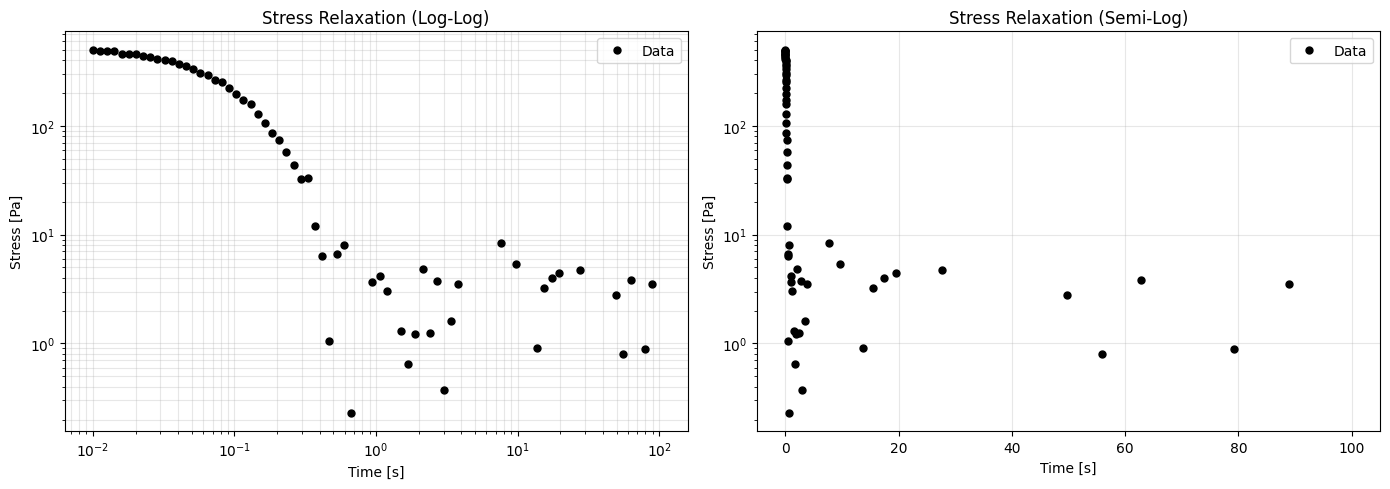

In [5]:
# Visualize relaxation data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log plot
ax1.loglog(t_data, stress, "ko", markersize=5, label="Data")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Stress Relaxation (Log-Log)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Semi-log plot (to show deviation from exponential)
ax2.semilogy(t_data, stress, "ko", markersize=5, label="Data")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Stress Relaxation (Semi-Log)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 4. NLSQ Fitting

### 4.1 Fit FluidityLocal to Relaxation Data

In [6]:
model = FluidityLocal()

t0_fit = time.perf_counter()
model.fit(t_data, stress, test_mode="relaxation", sigma_0=stress[0], method='scipy')

# Compute fit quality
stress_pred_data = model.predict(t_data, test_mode="relaxation", sigma_0=stress[0])
metrics = compute_fit_quality(stress, stress_pred_data)
t_nlsq = time.perf_counter() - t0_fit

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters:")
param_names = ["G", "tau_y", "K", "n_flow", "f_eq", "f_inf", "theta", "a", "n_rejuv"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 27.02 s
R²: 0.712016
RMSE: 91.66 Pa

Fitted parameters:
  G          = 1.878e+05
  tau_y      = 831.4
  K          = 738.8
  n_flow     = 1.935
  f_eq       = 2.998e-08
  f_inf      = 0.0001891
  theta      = 0.2627
  a          = 1
  n_rejuv    = 1


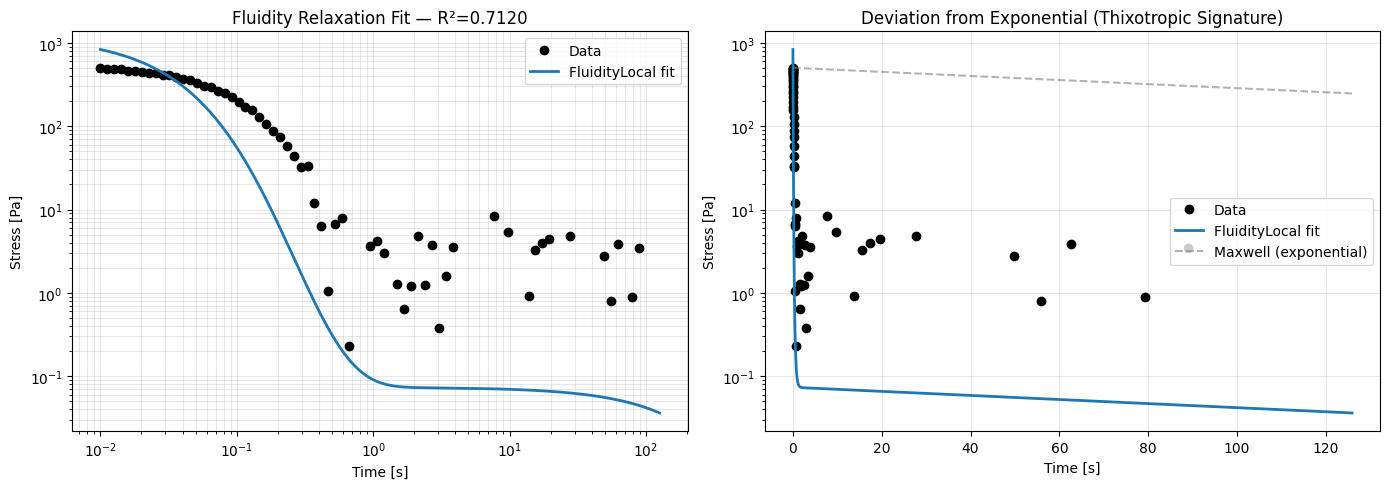

In [7]:
# Predict and compare
# t_fine must start at or after t_data.min() for ODE integration to work
t_fine = np.logspace(np.log10(t_data.min()), np.log10(t_data.max()) + 0.1, 200)
stress_pred = model.predict(t_fine, test_mode="relaxation", sigma_0=stress[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log
ax1.loglog(t_data, stress, "ko", markersize=6, label="Data")
ax1.loglog(t_fine, stress_pred, "-", lw=2, color="C0", label="FluidityLocal fit")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"Fluidity Relaxation Fit — R²={metrics['R2']:.4f}")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Semi-log (curvature = non-exponential)
ax2.semilogy(t_data, stress, "ko", markersize=6, label="Data")
ax2.semilogy(t_fine, stress_pred, "-", lw=2, color="C0", label="FluidityLocal fit")

# Reference exponential for comparison (Maxwell with tau = 1/(G*f_eq))
G_fit = model.parameters.get_value("G")
f_eq_fit = model.parameters.get_value("f_eq")
tau_maxwell = 1.0 / (G_fit * f_eq_fit + 1e-30)
stress_maxwell = stress[0] * np.exp(-t_fine / tau_maxwell)
ax2.semilogy(
    t_fine, stress_maxwell, "--", lw=1.5, color="gray", alpha=0.6, label="Maxwell (exponential)"
)

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Deviation from Exponential (Thixotropic Signature)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

### 4.2 Fluidity Evolution During Relaxation

To visualize the thixotropic aging mechanism, we simulate the fluidity evolution f(t) during relaxation.

In [8]:
# Simulate fluidity evolution using diffrax
from rheojax.models.fluidity._kernels import fluidity_local_ode_rhs
import diffrax

# Get fitted parameters
p = model.get_parameter_dict()
f_init = p["f_inf"]  # Start with high fluidity (just flowed)
sigma_init = stress[0]

# ODE arguments
args = {
    "G": p["G"],
    "f_eq": p["f_eq"],
    "f_inf": p["f_inf"],
    "theta": p["theta"],
    "a": p["a"],
    "n_rejuv": p["n_rejuv"],
    "gamma_dot": 0.0,  # No flow during relaxation
}

# Initial state: [sigma, f]
y0 = jnp.array([sigma_init, f_init])

# Time span - use t_data bounds to ensure saveat is within bounds
t_span = jnp.array([t_data.min(), t_data.max()])

# t_fine must be within [t_span[0], t_span[1]] for diffrax saveat
t_fine_ode = np.linspace(float(t_data.min()), float(t_data.max()), 200)
saveat = diffrax.SaveAt(ts=jnp.asarray(t_fine_ode))

# Solve ODE
term = diffrax.ODETerm(fluidity_local_ode_rhs)
solver = diffrax.Tsit5()
stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-8)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t_span[0],
    t1=t_span[1],
    dt0=0.01,
    y0=y0,
    args=args,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=1_000_000,
)

stress_sim = np.array(sol.ys[:, 0])
fluidity_sim = np.array(sol.ys[:, 1])

print(f"Fluidity range: [{fluidity_sim.min():.4g}, {fluidity_sim.max():.4g}] 1/(Pa·s)")
print(f"f_eq (target): {p['f_eq']:.4g} 1/(Pa·s)")

Fluidity range: [2.992e-08, 0.0001891] 1/(Pa·s)
f_eq (target): 2.998e-08 1/(Pa·s)


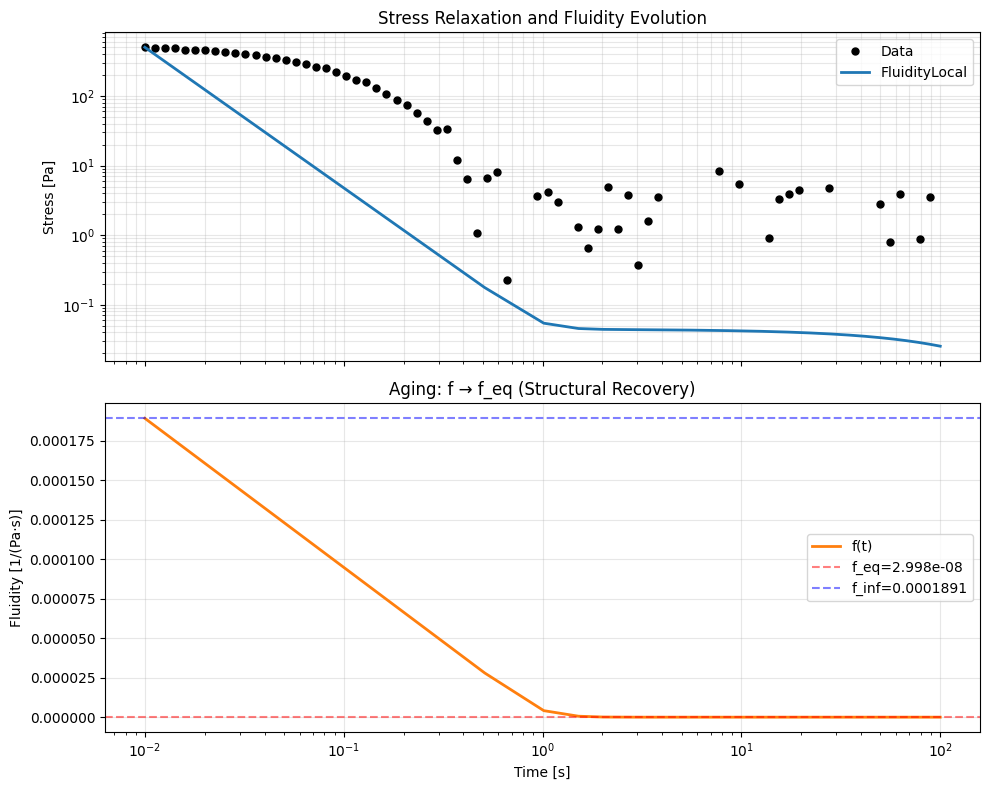

In [9]:
# Plot stress and fluidity evolution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Stress
ax1.loglog(t_data, stress, "ko", markersize=5, label="Data")
ax1.loglog(t_fine_ode, stress_sim, "-", lw=2, color="C0", label="FluidityLocal")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Stress Relaxation and Fluidity Evolution")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Fluidity
ax2.semilogx(t_fine_ode, fluidity_sim, "-", lw=2, color="C1", label="f(t)")
ax2.axhline(
    p["f_eq"], color="red", linestyle="--", alpha=0.5, lw=1.5, label=f"f_eq={p['f_eq']:.4g}"
)
ax2.axhline(
    p["f_inf"], color="blue", linestyle="--", alpha=0.5, lw=1.5, label=f"f_inf={p['f_inf']:.4g}"
)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Fluidity [1/(Pa·s)]")
ax2.set_title("Aging: f → f_eq (Structural Recovery)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

**Interpretation:**
- **Upper panel:** Stress decays non-exponentially (curved on semi-log plot)
- **Lower panel:** Fluidity f(t) decreases from f_inf (high, recent flow) toward f_eq (low, structural recovery)
- **Mechanism:** Lower f → slower stress relaxation → accelerating decay signature

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [10]:
initial_values = {name: model.parameters.get_value(name) for name in param_names}
print("Warm-start values:")
for name, val in initial_values.items():
    print(f"  {name:10s} = {val:.4g}")

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.perf_counter()
result = model.fit_bayesian(
    t_data,
    stress,
    test_mode="relaxation",
    sigma_0=stress[0],
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.perf_counter() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G          = 1.878e+05
  tau_y      = 831.4
  K          = 738.8
  n_flow     = 1.935
  f_eq       = 2.998e-08
  f_inf      = 0.0001891
  theta      = 0.2627
  a          = 1
  n_rejuv    = 1


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:04<48:37,  4.17s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 8/700 [00:04<04:36,  2.50it/s, 31 steps of size 1.03e-03. acc. prob=0.62]

warmup:   2%|▏         | 11/700 [00:04<03:13,  3.57it/s, 63 steps of size 1.08e-03. acc. prob=0.73]

warmup:   2%|▏         | 14/700 [00:05<03:07,  3.65it/s, 255 steps of size 1.31e-03. acc. prob=0.79]

warmup:   2%|▏         | 16/700 [00:07<05:24,  2.10it/s, 1023 steps of size 9.52e-04. acc. prob=0.80]

warmup:   2%|▏         | 17/700 [00:08<06:14,  1.82it/s, 1023 steps of size 9.81e-04. acc. prob=0.81]

warmup:   3%|▎         | 18/700 [00:09<07:36,  1.49it/s, 1023 steps of size 1.09e-03. acc. prob=0.82]

warmup:   3%|▎         | 19/700 [00:11<09:19,  1.22it/s, 1023 steps of size 1.20e-03. acc. prob=0.83]

warmup:   3%|▎         | 20/700 [00:12<11:00,  1.03it/s, 1023 steps of size 1.33e-03. acc. prob=0.84]

warmup:   3%|▎         | 21/700 [00:14<12:04,  1.07s/it, 1023 steps of size 1.45e-03. acc. prob=0.85]

warmup:   3%|▎         | 22/700 [00:15<12:59,  1.15s/it, 1023 steps of size 1.58e-03. acc. prob=0.85]

warmup:   3%|▎         | 23/700 [00:16<13:47,  1.22s/it, 1023 steps of size 1.66e-03. acc. prob=0.86]

warmup:   3%|▎         | 24/700 [00:18<14:06,  1.25s/it, 1023 steps of size 1.80e-03. acc. prob=0.87]

warmup:   4%|▎         | 25/700 [00:19<13:44,  1.22s/it, 1023 steps of size 1.30e-03. acc. prob=0.86]

warmup:   4%|▎         | 26/700 [00:20<13:12,  1.18s/it, 1023 steps of size 1.19e-03. acc. prob=0.87]

warmup:   4%|▍         | 27/700 [00:21<13:20,  1.19s/it, 1023 steps of size 1.33e-03. acc. prob=0.87]

warmup:   4%|▍         | 28/700 [00:24<19:18,  1.72s/it, 1023 steps of size 1.42e-03. acc. prob=0.88]

warmup:   4%|▍         | 29/700 [00:28<26:16,  2.35s/it, 1023 steps of size 1.56e-03. acc. prob=0.88]

warmup:   4%|▍         | 30/700 [00:32<31:55,  2.86s/it, 1023 steps of size 1.62e-03. acc. prob=0.88]

warmup:   4%|▍         | 31/700 [00:36<34:45,  3.12s/it, 1023 steps of size 1.64e-03. acc. prob=0.89]

warmup:   5%|▍         | 32/700 [00:39<36:37,  3.29s/it, 1023 steps of size 1.80e-03. acc. prob=0.89]

warmup:   5%|▍         | 33/700 [00:43<37:51,  3.41s/it, 1023 steps of size 1.87e-03. acc. prob=0.89]

warmup:   5%|▍         | 34/700 [00:47<37:56,  3.42s/it, 1023 steps of size 1.76e-03. acc. prob=0.89]

warmup:   5%|▌         | 35/700 [00:50<38:22,  3.46s/it, 1023 steps of size 1.61e-03. acc. prob=0.90]

warmup:   5%|▌         | 36/700 [00:54<40:49,  3.69s/it, 1023 steps of size 1.77e-03. acc. prob=0.90]

warmup:   5%|▌         | 37/700 [00:59<43:59,  3.98s/it, 1023 steps of size 1.69e-03. acc. prob=0.90]

warmup:   5%|▌         | 38/700 [01:03<45:20,  4.11s/it, 1023 steps of size 1.73e-03. acc. prob=0.90]

warmup:   6%|▌         | 39/700 [01:08<46:12,  4.19s/it, 1023 steps of size 1.78e-03. acc. prob=0.90]

warmup:   6%|▌         | 40/700 [01:12<47:05,  4.28s/it, 1023 steps of size 1.81e-03. acc. prob=0.90]

warmup:   6%|▌         | 41/700 [01:17<48:13,  4.39s/it, 1023 steps of size 1.97e-03. acc. prob=0.91]

warmup:   6%|▌         | 42/700 [01:21<48:33,  4.43s/it, 1023 steps of size 2.15e-03. acc. prob=0.91]

warmup:   6%|▌         | 43/700 [01:26<48:50,  4.46s/it, 1023 steps of size 2.25e-03. acc. prob=0.91]

warmup:   6%|▋         | 44/700 [01:31<49:27,  4.52s/it, 1023 steps of size 2.43e-03. acc. prob=0.91]

warmup:   6%|▋         | 45/700 [01:35<49:55,  4.57s/it, 1023 steps of size 2.61e-03. acc. prob=0.91]

warmup:   7%|▋         | 46/700 [01:40<49:30,  4.54s/it, 1023 steps of size 2.79e-03. acc. prob=0.92]

warmup:   7%|▋         | 47/700 [01:45<50:43,  4.66s/it, 1023 steps of size 1.95e-03. acc. prob=0.91]

warmup:   7%|▋         | 48/700 [01:49<50:36,  4.66s/it, 1023 steps of size 2.11e-03. acc. prob=0.92]

warmup:   7%|▋         | 49/700 [01:54<50:42,  4.67s/it, 1023 steps of size 2.27e-03. acc. prob=0.92]

warmup:   7%|▋         | 50/700 [01:59<50:42,  4.68s/it, 1023 steps of size 2.18e-03. acc. prob=0.92]

warmup:   7%|▋         | 51/700 [02:03<50:13,  4.64s/it, 1023 steps of size 1.92e-03. acc. prob=0.92]

warmup:   7%|▋         | 52/700 [02:08<50:58,  4.72s/it, 1023 steps of size 1.02e-03. acc. prob=0.91]

warmup:   8%|▊         | 53/700 [02:13<50:04,  4.64s/it, 1023 steps of size 1.10e-03. acc. prob=0.92]

warmup:   8%|▊         | 54/700 [02:18<52:14,  4.85s/it, 1023 steps of size 1.19e-03. acc. prob=0.92]

warmup:   8%|▊         | 55/700 [02:23<51:50,  4.82s/it, 1023 steps of size 1.24e-03. acc. prob=0.92]

warmup:   8%|▊         | 56/700 [02:23<38:00,  3.54s/it, 127 steps of size 1.26e-03. acc. prob=0.92] 

warmup:   8%|▊         | 57/700 [02:26<35:27,  3.31s/it, 663 steps of size 1.33e-03. acc. prob=0.92]

warmup:   8%|▊         | 58/700 [02:31<39:18,  3.67s/it, 1023 steps of size 1.43e-03. acc. prob=0.92]

warmup:   8%|▊         | 59/700 [02:35<42:30,  3.98s/it, 1023 steps of size 1.44e-03. acc. prob=0.92]

warmup:   9%|▊         | 60/700 [02:40<44:30,  4.17s/it, 1023 steps of size 1.55e-03. acc. prob=0.92]

warmup:   9%|▊         | 61/700 [02:45<46:00,  4.32s/it, 1023 steps of size 1.62e-03. acc. prob=0.92]

warmup:   9%|▉         | 62/700 [02:49<46:07,  4.34s/it, 1023 steps of size 1.72e-03. acc. prob=0.93]

warmup:   9%|▉         | 63/700 [02:54<47:38,  4.49s/it, 1023 steps of size 1.82e-03. acc. prob=0.93]

warmup:   9%|▉         | 64/700 [02:58<47:54,  4.52s/it, 1023 steps of size 1.90e-03. acc. prob=0.93]

warmup:   9%|▉         | 65/700 [03:03<48:40,  4.60s/it, 1023 steps of size 1.71e-03. acc. prob=0.93]

warmup:   9%|▉         | 66/700 [03:08<49:30,  4.69s/it, 1023 steps of size 1.76e-03. acc. prob=0.93]

warmup:  10%|▉         | 67/700 [03:13<49:09,  4.66s/it, 1023 steps of size 1.88e-03. acc. prob=0.93]

warmup:  10%|▉         | 68/700 [03:17<49:19,  4.68s/it, 1023 steps of size 1.83e-03. acc. prob=0.93]

warmup:  10%|▉         | 69/700 [03:22<49:32,  4.71s/it, 1023 steps of size 1.96e-03. acc. prob=0.93]

warmup:  10%|█         | 70/700 [03:27<49:00,  4.67s/it, 1023 steps of size 2.07e-03. acc. prob=0.93]

warmup:  10%|█         | 71/700 [03:32<49:07,  4.69s/it, 1023 steps of size 2.01e-03. acc. prob=0.93]

warmup:  10%|█         | 72/700 [03:36<49:33,  4.74s/it, 1023 steps of size 1.85e-03. acc. prob=0.93]

warmup:  10%|█         | 73/700 [03:41<49:40,  4.75s/it, 1023 steps of size 1.47e-03. acc. prob=0.93]

warmup:  11%|█         | 74/700 [03:46<49:24,  4.73s/it, 1023 steps of size 1.57e-03. acc. prob=0.93]

warmup:  11%|█         | 75/700 [03:51<49:16,  4.73s/it, 1023 steps of size 1.67e-03. acc. prob=0.93]

warmup:  11%|█         | 76/700 [03:55<48:31,  4.67s/it, 1023 steps of size 1.67e-03. acc. prob=0.93]

warmup:  11%|█         | 77/700 [04:00<48:53,  4.71s/it, 1023 steps of size 1.78e-03. acc. prob=0.93]

warmup:  11%|█         | 78/700 [04:06<52:44,  5.09s/it, 1023 steps of size 1.89e-03. acc. prob=0.94]

warmup:  11%|█▏        | 79/700 [04:12<56:55,  5.50s/it, 1023 steps of size 1.97e-03. acc. prob=0.94]

warmup:  11%|█▏        | 80/700 [04:18<57:58,  5.61s/it, 1023 steps of size 2.07e-03. acc. prob=0.94]

warmup:  12%|█▏        | 81/700 [04:24<58:16,  5.65s/it, 1023 steps of size 2.09e-03. acc. prob=0.94]

warmup:  12%|█▏        | 82/700 [04:30<58:21,  5.67s/it, 1023 steps of size 2.04e-03. acc. prob=0.94]

warmup:  12%|█▏        | 83/700 [04:35<57:52,  5.63s/it, 1023 steps of size 2.13e-03. acc. prob=0.94]

warmup:  12%|█▏        | 84/700 [04:41<59:03,  5.75s/it, 1023 steps of size 1.96e-03. acc. prob=0.94]

warmup:  12%|█▏        | 85/700 [04:48<1:00:46,  5.93s/it, 1023 steps of size 2.01e-03. acc. prob=0.94]

warmup:  12%|█▏        | 86/700 [04:55<1:04:19,  6.29s/it, 1023 steps of size 2.10e-03. acc. prob=0.94]

warmup:  12%|█▏        | 87/700 [05:04<1:13:42,  7.21s/it, 1023 steps of size 2.05e-03. acc. prob=0.94]

warmup:  13%|█▎        | 88/700 [05:10<1:09:07,  6.78s/it, 1023 steps of size 1.85e-03. acc. prob=0.94]

warmup:  13%|█▎        | 89/700 [05:15<1:03:05,  6.20s/it, 1023 steps of size 1.63e-03. acc. prob=0.94]

warmup:  13%|█▎        | 90/700 [05:16<49:19,  4.85s/it, 383 steps of size 1.72e-03. acc. prob=0.94]   

warmup:  13%|█▎        | 91/700 [05:22<50:09,  4.94s/it, 1023 steps of size 1.83e-03. acc. prob=0.94]

warmup:  13%|█▎        | 92/700 [05:27<53:00,  5.23s/it, 1023 steps of size 1.83e-03. acc. prob=0.94]

warmup:  13%|█▎        | 93/700 [05:34<57:26,  5.68s/it, 1023 steps of size 1.52e-03. acc. prob=0.94]

warmup:  13%|█▎        | 94/700 [05:42<1:03:27,  6.28s/it, 1023 steps of size 1.54e-03. acc. prob=0.94]

warmup:  14%|█▎        | 95/700 [06:00<1:39:47,  9.90s/it, 1023 steps of size 1.60e-03. acc. prob=0.94]

warmup:  14%|█▎        | 96/700 [06:28<2:32:12, 15.12s/it, 1023 steps of size 1.69e-03. acc. prob=0.94]

warmup:  14%|█▍        | 97/700 [06:45<2:39:02, 15.83s/it, 1023 steps of size 1.66e-03. acc. prob=0.94]

warmup:  14%|█▍        | 98/700 [06:52<2:11:41, 13.13s/it, 1023 steps of size 1.75e-03. acc. prob=0.94]

warmup:  14%|█▍        | 99/700 [06:58<1:49:45, 10.96s/it, 1023 steps of size 1.79e-03. acc. prob=0.94]

warmup:  14%|█▍        | 100/700 [07:03<1:31:26,  9.14s/it, 1023 steps of size 1.38e-03. acc. prob=0.94]

warmup:  14%|█▍        | 101/700 [07:10<1:26:20,  8.65s/it, 1023 steps of size 1.40e-02. acc. prob=0.94]

warmup:  15%|█▍        | 103/700 [07:16<1:00:45,  6.11s/it, 1023 steps of size 1.06e-03. acc. prob=0.93]

warmup:  15%|█▍        | 104/700 [07:21<57:47,  5.82s/it, 1023 steps of size 9.11e-04. acc. prob=0.93]  

warmup:  15%|█▌        | 105/700 [07:26<54:55,  5.54s/it, 1023 steps of size 8.34e-04. acc. prob=0.93]

warmup:  15%|█▌        | 106/700 [07:31<53:03,  5.36s/it, 1023 steps of size 7.97e-04. acc. prob=0.94]

warmup:  15%|█▌        | 107/700 [07:36<51:17,  5.19s/it, 1023 steps of size 7.79e-04. acc. prob=0.94]

warmup:  15%|█▌        | 108/700 [07:40<49:32,  5.02s/it, 1023 steps of size 7.79e-04. acc. prob=0.94]

warmup:  16%|█▌        | 109/700 [07:45<49:10,  4.99s/it, 1023 steps of size 7.92e-04. acc. prob=0.94]

warmup:  16%|█▌        | 110/700 [07:50<47:37,  4.84s/it, 1023 steps of size 8.06e-04. acc. prob=0.94]

warmup:  16%|█▌        | 111/700 [07:54<47:17,  4.82s/it, 1023 steps of size 8.34e-04. acc. prob=0.94]

warmup:  16%|█▌        | 112/700 [07:59<47:23,  4.84s/it, 1023 steps of size 8.68e-04. acc. prob=0.94]

warmup:  16%|█▌        | 113/700 [08:04<47:07,  4.82s/it, 1023 steps of size 9.00e-04. acc. prob=0.94]

warmup:  16%|█▋        | 114/700 [08:09<47:29,  4.86s/it, 1023 steps of size 9.35e-04. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [08:14<47:11,  4.84s/it, 1023 steps of size 9.80e-04. acc. prob=0.94]

warmup:  17%|█▋        | 116/700 [08:18<46:08,  4.74s/it, 1023 steps of size 1.01e-03. acc. prob=0.94]

warmup:  17%|█▋        | 117/700 [08:23<46:35,  4.79s/it, 1023 steps of size 1.06e-03. acc. prob=0.94]

warmup:  17%|█▋        | 118/700 [08:28<45:15,  4.67s/it, 1023 steps of size 1.12e-03. acc. prob=0.94]

warmup:  17%|█▋        | 119/700 [08:32<45:30,  4.70s/it, 1023 steps of size 1.17e-03. acc. prob=0.94]

warmup:  17%|█▋        | 120/700 [08:38<47:05,  4.87s/it, 1023 steps of size 1.22e-03. acc. prob=0.94]

warmup:  17%|█▋        | 121/700 [08:44<51:52,  5.38s/it, 1023 steps of size 1.29e-03. acc. prob=0.94]

warmup:  17%|█▋        | 122/700 [08:51<54:28,  5.65s/it, 1023 steps of size 1.35e-03. acc. prob=0.94]

warmup:  18%|█▊        | 123/700 [08:56<54:59,  5.72s/it, 1023 steps of size 1.41e-03. acc. prob=0.94]

warmup:  18%|█▊        | 124/700 [09:03<58:38,  6.11s/it, 1023 steps of size 1.48e-03. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [09:08<55:21,  5.78s/it, 1023 steps of size 1.46e-03. acc. prob=0.94]

warmup:  18%|█▊        | 126/700 [09:13<53:00,  5.54s/it, 1023 steps of size 1.52e-03. acc. prob=0.95]

warmup:  18%|█▊        | 127/700 [09:19<53:13,  5.57s/it, 1023 steps of size 1.59e-03. acc. prob=0.95]

warmup:  18%|█▊        | 128/700 [09:25<54:09,  5.68s/it, 1023 steps of size 1.66e-03. acc. prob=0.95]

warmup:  18%|█▊        | 129/700 [09:35<1:05:34,  6.89s/it, 1023 steps of size 1.74e-03. acc. prob=0.95]

warmup:  19%|█▊        | 130/700 [09:47<1:19:37,  8.38s/it, 1023 steps of size 1.80e-03. acc. prob=0.95]

warmup:  19%|█▊        | 131/700 [09:51<1:08:50,  7.26s/it, 1023 steps of size 1.86e-03. acc. prob=0.95]

warmup:  19%|█▉        | 132/700 [09:58<1:07:03,  7.08s/it, 1023 steps of size 1.95e-03. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [10:04<1:04:13,  6.80s/it, 1023 steps of size 2.00e-03. acc. prob=0.95]

warmup:  19%|█▉        | 134/700 [10:10<1:01:07,  6.48s/it, 1023 steps of size 2.08e-03. acc. prob=0.95]

warmup:  19%|█▉        | 135/700 [10:15<58:19,  6.19s/it, 1023 steps of size 2.16e-03. acc. prob=0.95]  

warmup:  19%|█▉        | 136/700 [10:21<58:07,  6.18s/it, 1023 steps of size 2.25e-03. acc. prob=0.95]

warmup:  20%|█▉        | 137/700 [10:27<56:38,  6.04s/it, 1023 steps of size 2.34e-03. acc. prob=0.95]

warmup:  20%|█▉        | 138/700 [10:33<55:02,  5.88s/it, 1023 steps of size 2.43e-03. acc. prob=0.95]

warmup:  20%|█▉        | 139/700 [10:40<58:05,  6.21s/it, 1023 steps of size 2.24e-03. acc. prob=0.95]

warmup:  20%|██        | 140/700 [10:46<58:11,  6.23s/it, 1023 steps of size 2.31e-03. acc. prob=0.95]

warmup:  20%|██        | 141/700 [10:51<55:25,  5.95s/it, 1023 steps of size 2.22e-03. acc. prob=0.95]

warmup:  20%|██        | 142/700 [10:57<55:45,  6.00s/it, 1023 steps of size 2.28e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [11:02<52:41,  5.68s/it, 1023 steps of size 2.37e-03. acc. prob=0.95]

warmup:  21%|██        | 144/700 [11:07<49:43,  5.37s/it, 1023 steps of size 2.22e-03. acc. prob=0.95]

warmup:  21%|██        | 145/700 [11:12<48:20,  5.23s/it, 1023 steps of size 2.30e-03. acc. prob=0.95]

warmup:  21%|██        | 146/700 [11:17<47:23,  5.13s/it, 1023 steps of size 2.10e-03. acc. prob=0.95]

warmup:  21%|██        | 147/700 [11:22<46:16,  5.02s/it, 1023 steps of size 2.17e-03. acc. prob=0.95]

warmup:  21%|██        | 148/700 [11:26<44:02,  4.79s/it, 1023 steps of size 2.19e-03. acc. prob=0.95]

warmup:  21%|██▏       | 149/700 [11:30<42:33,  4.63s/it, 1023 steps of size 2.28e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [11:34<41:20,  4.51s/it, 1023 steps of size 2.36e-03. acc. prob=0.95]

warmup:  22%|██▏       | 151/700 [11:38<40:25,  4.42s/it, 1023 steps of size 2.40e-02. acc. prob=0.95]

warmup:  22%|██▏       | 153/700 [11:43<30:58,  3.40s/it, 1023 steps of size 1.76e-03. acc. prob=0.95]

warmup:  22%|██▏       | 154/700 [11:47<33:27,  3.68s/it, 1023 steps of size 1.49e-03. acc. prob=0.95]

warmup:  22%|██▏       | 155/700 [11:52<34:57,  3.85s/it, 1023 steps of size 1.21e-03. acc. prob=0.95]

warmup:  22%|██▏       | 156/700 [11:56<36:02,  3.97s/it, 1023 steps of size 1.15e-03. acc. prob=0.95]

warmup:  22%|██▏       | 157/700 [12:01<38:08,  4.21s/it, 1023 steps of size 1.08e-03. acc. prob=0.95]

warmup:  23%|██▎       | 158/700 [12:06<40:27,  4.48s/it, 1023 steps of size 1.08e-03. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [12:11<42:35,  4.72s/it, 1023 steps of size 1.09e-03. acc. prob=0.95]

warmup:  23%|██▎       | 160/700 [12:17<43:58,  4.89s/it, 1023 steps of size 1.12e-03. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [12:24<49:20,  5.49s/it, 1023 steps of size 1.10e-03. acc. prob=0.95]

warmup:  23%|██▎       | 162/700 [12:32<55:53,  6.23s/it, 1023 steps of size 1.14e-03. acc. prob=0.95]

warmup:  23%|██▎       | 163/700 [12:40<1:02:49,  7.02s/it, 1023 steps of size 1.20e-03. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [12:48<1:05:06,  7.29s/it, 1023 steps of size 1.25e-03. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [12:56<1:04:53,  7.28s/it, 1023 steps of size 1.28e-03. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [13:05<1:11:19,  8.01s/it, 1023 steps of size 1.30e-03. acc. prob=0.95]

warmup:  24%|██▍       | 167/700 [13:18<1:23:17,  9.38s/it, 1023 steps of size 1.35e-03. acc. prob=0.95]

warmup:  24%|██▍       | 168/700 [13:23<1:12:24,  8.17s/it, 1023 steps of size 1.42e-03. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [13:28<1:03:55,  7.22s/it, 1023 steps of size 1.23e-03. acc. prob=0.95]

warmup:  24%|██▍       | 170/700 [13:35<1:01:46,  6.99s/it, 1023 steps of size 1.28e-03. acc. prob=0.95]

warmup:  24%|██▍       | 171/700 [13:42<1:03:12,  7.17s/it, 1023 steps of size 1.22e-03. acc. prob=0.95]

warmup:  25%|██▍       | 172/700 [13:51<1:08:16,  7.76s/it, 1023 steps of size 1.26e-03. acc. prob=0.95]

warmup:  25%|██▍       | 173/700 [14:00<1:09:40,  7.93s/it, 1023 steps of size 1.29e-03. acc. prob=0.95]

warmup:  25%|██▍       | 174/700 [14:07<1:06:53,  7.63s/it, 1023 steps of size 1.27e-03. acc. prob=0.95]

warmup:  25%|██▌       | 175/700 [14:13<1:04:26,  7.36s/it, 1023 steps of size 1.29e-03. acc. prob=0.95]

warmup:  25%|██▌       | 176/700 [14:20<1:01:21,  7.03s/it, 1023 steps of size 1.35e-03. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [14:26<59:51,  6.87s/it, 1023 steps of size 1.42e-03. acc. prob=0.95]  

warmup:  25%|██▌       | 178/700 [14:32<58:09,  6.68s/it, 1023 steps of size 1.49e-03. acc. prob=0.95]

warmup:  26%|██▌       | 179/700 [14:39<56:56,  6.56s/it, 1023 steps of size 1.57e-03. acc. prob=0.95]

warmup:  26%|██▌       | 180/700 [14:45<57:14,  6.60s/it, 1023 steps of size 1.57e-03. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [14:52<58:10,  6.73s/it, 1023 steps of size 1.65e-03. acc. prob=0.95]

warmup:  26%|██▌       | 182/700 [15:00<1:00:48,  7.04s/it, 1023 steps of size 1.71e-03. acc. prob=0.95]

warmup:  26%|██▌       | 183/700 [15:12<1:12:06,  8.37s/it, 1023 steps of size 1.79e-03. acc. prob=0.95]

warmup:  26%|██▋       | 184/700 [15:26<1:26:21, 10.04s/it, 1023 steps of size 1.81e-03. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [15:38<1:32:05, 10.73s/it, 1023 steps of size 1.88e-03. acc. prob=0.95]

warmup:  27%|██▋       | 186/700 [15:51<1:39:06, 11.57s/it, 1023 steps of size 1.78e-03. acc. prob=0.95]

warmup:  27%|██▋       | 187/700 [15:59<1:29:10, 10.43s/it, 1023 steps of size 1.86e-03. acc. prob=0.95]

warmup:  27%|██▋       | 188/700 [16:06<1:19:04,  9.27s/it, 1023 steps of size 1.50e-03. acc. prob=0.95]

warmup:  27%|██▋       | 189/700 [16:10<1:05:54,  7.74s/it, 1023 steps of size 1.35e-03. acc. prob=0.95]

warmup:  27%|██▋       | 190/700 [16:14<57:30,  6.77s/it, 1023 steps of size 1.41e-03. acc. prob=0.95]  

warmup:  27%|██▋       | 191/700 [16:19<52:01,  6.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [16:24<48:29,  5.73s/it, 1023 steps of size 1.40e-03. acc. prob=0.95]

warmup:  28%|██▊       | 193/700 [16:29<45:59,  5.44s/it, 1023 steps of size 1.42e-03. acc. prob=0.95]

warmup:  28%|██▊       | 194/700 [16:35<48:19,  5.73s/it, 1023 steps of size 1.49e-03. acc. prob=0.96]

warmup:  28%|██▊       | 195/700 [16:42<50:08,  5.96s/it, 1023 steps of size 1.55e-03. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [16:46<45:18,  5.39s/it, 1023 steps of size 1.61e-03. acc. prob=0.96]

warmup:  28%|██▊       | 197/700 [16:50<42:54,  5.12s/it, 1023 steps of size 1.47e-03. acc. prob=0.96]

warmup:  28%|██▊       | 198/700 [16:55<41:36,  4.97s/it, 1023 steps of size 1.49e-03. acc. prob=0.96]

warmup:  28%|██▊       | 199/700 [16:59<40:54,  4.90s/it, 1023 steps of size 1.37e-03. acc. prob=0.96]

warmup:  29%|██▊       | 200/700 [17:04<39:30,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.96]

sample:  29%|██▊       | 201/700 [17:09<39:27,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.95]

sample:  29%|██▉       | 202/700 [17:13<38:55,  4.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.97]

sample:  29%|██▉       | 203/700 [17:18<38:24,  4.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  29%|██▉       | 204/700 [17:22<37:33,  4.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  29%|██▉       | 205/700 [17:27<37:47,  4.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  29%|██▉       | 206/700 [17:31<37:06,  4.51s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  30%|██▉       | 207/700 [17:36<37:42,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  30%|██▉       | 208/700 [17:41<39:45,  4.85s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  30%|██▉       | 209/700 [17:48<44:07,  5.39s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  30%|███       | 210/700 [17:56<50:52,  6.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  30%|███       | 211/700 [18:06<1:00:09,  7.38s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  30%|███       | 212/700 [18:13<58:37,  7.21s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]  

sample:  30%|███       | 213/700 [18:18<52:40,  6.49s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███       | 214/700 [18:23<48:45,  6.02s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███       | 215/700 [18:28<46:15,  5.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███       | 216/700 [18:33<44:01,  5.46s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███       | 217/700 [18:38<42:43,  5.31s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███       | 218/700 [18:42<41:14,  5.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [18:48<41:37,  5.19s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [18:53<41:10,  5.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [18:57<40:04,  5.02s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [19:02<39:21,  4.94s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [19:08<41:13,  5.19s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [19:13<41:19,  5.21s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  32%|███▏      | 225/700 [19:19<42:25,  5.36s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [19:28<50:35,  6.40s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [19:38<59:40,  7.57s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  33%|███▎      | 228/700 [19:44<55:30,  7.06s/it, 1023 steps of size 1.48e-03. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [19:49<50:00,  6.37s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  33%|███▎      | 230/700 [19:54<47:54,  6.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  33%|███▎      | 231/700 [20:01<48:49,  6.25s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  33%|███▎      | 232/700 [20:08<50:16,  6.44s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  33%|███▎      | 233/700 [20:18<58:47,  7.55s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  33%|███▎      | 234/700 [20:28<1:06:04,  8.51s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▎      | 235/700 [20:36<1:04:37,  8.34s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▎      | 236/700 [20:47<1:10:06,  9.07s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▍      | 237/700 [20:59<1:16:19,  9.89s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▍      | 238/700 [21:14<1:27:52, 11.41s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▍      | 239/700 [21:27<1:31:18, 11.88s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▍      | 240/700 [21:37<1:27:29, 11.41s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [21:48<1:26:10, 11.26s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▍      | 242/700 [21:56<1:18:24, 10.27s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▍      | 243/700 [22:03<1:11:29,  9.39s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▍      | 244/700 [22:11<1:07:54,  8.94s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▌      | 245/700 [22:23<1:13:45,  9.73s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▌      | 246/700 [22:39<1:27:10, 11.52s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▌      | 247/700 [22:53<1:34:38, 12.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  35%|███▌      | 248/700 [23:08<1:38:25, 13.06s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▌      | 249/700 [23:20<1:37:24, 12.96s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▌      | 250/700 [23:35<1:40:30, 13.40s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▌      | 251/700 [23:49<1:40:59, 13.49s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▌      | 252/700 [24:03<1:42:19, 13.70s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▌      | 253/700 [24:14<1:36:59, 13.02s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▋      | 254/700 [24:22<1:25:48, 11.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  36%|███▋      | 255/700 [24:31<1:18:04, 10.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  37%|███▋      | 256/700 [24:35<1:05:00,  8.78s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  37%|███▋      | 257/700 [24:40<55:22,  7.50s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]  

sample:  37%|███▋      | 258/700 [24:45<49:29,  6.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  37%|███▋      | 259/700 [24:49<45:08,  6.14s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  37%|███▋      | 260/700 [24:55<42:50,  5.84s/it, 968 steps of size 1.48e-03. acc. prob=0.98] 

sample:  37%|███▋      | 261/700 [24:59<40:41,  5.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  37%|███▋      | 262/700 [25:01<32:34,  4.46s/it, 349 steps of size 1.48e-03. acc. prob=0.98] 

sample:  38%|███▊      | 263/700 [25:06<32:36,  4.48s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  38%|███▊      | 264/700 [25:10<32:21,  4.45s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  38%|███▊      | 265/700 [25:15<32:56,  4.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  38%|███▊      | 266/700 [25:20<33:10,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  38%|███▊      | 267/700 [25:25<34:35,  4.79s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  38%|███▊      | 268/700 [25:30<34:05,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  38%|███▊      | 269/700 [25:35<34:53,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▊      | 270/700 [25:40<35:10,  4.91s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▊      | 271/700 [25:45<35:05,  4.91s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▉      | 272/700 [25:50<35:07,  4.92s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▉      | 273/700 [25:54<34:16,  4.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▉      | 274/700 [26:00<36:02,  5.08s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▉      | 275/700 [26:04<34:44,  4.91s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  39%|███▉      | 276/700 [26:09<34:58,  4.95s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|███▉      | 277/700 [26:14<34:04,  4.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|███▉      | 278/700 [26:19<33:53,  4.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|███▉      | 279/700 [26:24<33:55,  4.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|████      | 280/700 [26:28<33:41,  4.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|████      | 281/700 [26:33<33:54,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|████      | 282/700 [26:38<33:10,  4.76s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  40%|████      | 283/700 [26:43<33:05,  4.76s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████      | 284/700 [26:47<32:51,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████      | 285/700 [26:52<32:27,  4.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████      | 286/700 [26:57<33:19,  4.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████      | 287/700 [27:03<34:36,  5.03s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████      | 288/700 [27:07<34:13,  4.98s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████▏     | 289/700 [27:13<34:30,  5.04s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  41%|████▏     | 290/700 [27:18<35:30,  5.20s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 291/700 [27:25<39:10,  5.75s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 292/700 [27:34<44:46,  6.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 293/700 [27:41<46:10,  6.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 294/700 [27:48<46:51,  6.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 295/700 [27:57<50:57,  7.55s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 296/700 [28:07<54:39,  8.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  42%|████▏     | 297/700 [28:16<56:46,  8.45s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [28:24<55:55,  8.35s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  43%|████▎     | 299/700 [28:33<57:21,  8.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  43%|████▎     | 300/700 [28:42<58:07,  8.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  43%|████▎     | 301/700 [28:52<1:00:14,  9.06s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  43%|████▎     | 302/700 [29:02<1:01:13,  9.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  43%|████▎     | 303/700 [29:10<59:05,  8.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]  

sample:  43%|████▎     | 304/700 [29:16<52:39,  7.98s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▎     | 305/700 [29:21<46:53,  7.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▎     | 306/700 [29:26<42:43,  6.51s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▍     | 307/700 [29:32<41:13,  6.29s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▍     | 308/700 [29:38<40:12,  6.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▍     | 309/700 [29:44<40:06,  6.16s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▍     | 310/700 [29:51<43:09,  6.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  44%|████▍     | 311/700 [30:28<1:40:54, 15.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▍     | 312/700 [31:04<2:20:49, 21.78s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▍     | 313/700 [31:17<2:03:22, 19.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▍     | 314/700 [31:26<1:42:24, 15.92s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▌     | 315/700 [31:34<1:28:27, 13.79s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▌     | 316/700 [31:42<1:17:19, 12.08s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▌     | 317/700 [32:02<1:31:37, 14.35s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  45%|████▌     | 318/700 [32:16<1:30:03, 14.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  46%|████▌     | 319/700 [32:21<1:13:16, 11.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  46%|████▌     | 320/700 [32:27<1:01:27,  9.70s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  46%|████▌     | 321/700 [32:31<51:52,  8.21s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]  

sample:  46%|████▌     | 322/700 [32:37<47:08,  7.48s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  46%|████▌     | 323/700 [32:43<43:34,  6.94s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  46%|████▋     | 324/700 [32:50<43:05,  6.88s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  46%|████▋     | 325/700 [32:56<42:42,  6.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 326/700 [33:03<42:34,  6.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 327/700 [33:08<39:21,  6.33s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 328/700 [33:13<36:20,  5.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 329/700 [33:19<35:46,  5.79s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 330/700 [33:24<34:17,  5.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 331/700 [33:29<32:59,  5.36s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  47%|████▋     | 332/700 [33:34<33:08,  5.40s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 333/700 [33:42<37:50,  6.19s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 334/700 [33:51<43:24,  7.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 335/700 [34:16<1:15:46, 12.46s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 336/700 [34:32<1:21:24, 13.42s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 337/700 [34:45<1:19:58, 13.22s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 338/700 [34:58<1:20:09, 13.29s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  48%|████▊     | 339/700 [35:20<1:35:28, 15.87s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  49%|████▊     | 340/700 [35:43<1:48:33, 18.09s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  49%|████▊     | 341/700 [36:11<2:05:37, 20.99s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  49%|████▉     | 342/700 [36:47<2:32:20, 25.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  49%|████▉     | 343/700 [37:15<2:36:20, 26.28s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  49%|████▉     | 344/700 [37:49<2:49:05, 28.50s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  49%|████▉     | 345/700 [37:55<2:08:07, 21.66s/it, 215 steps of size 1.48e-03. acc. prob=0.98] 

sample:  49%|████▉     | 346/700 [38:17<2:08:32, 21.79s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|████▉     | 347/700 [38:41<2:13:31, 22.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|████▉     | 348/700 [39:14<2:30:11, 25.60s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|████▉     | 349/700 [39:29<2:11:20, 22.45s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|█████     | 350/700 [39:34<1:40:19, 17.20s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|█████     | 351/700 [39:39<1:18:05, 13.42s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|█████     | 352/700 [39:44<1:03:47, 11.00s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  50%|█████     | 353/700 [39:50<55:08,  9.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]  

sample:  51%|█████     | 354/700 [39:55<47:17,  8.20s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  51%|█████     | 355/700 [40:01<43:47,  7.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  51%|█████     | 356/700 [40:24<1:10:10, 12.24s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  51%|█████     | 357/700 [40:48<1:28:50, 15.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  51%|█████     | 358/700 [40:53<1:12:01, 12.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  51%|█████▏    | 359/700 [40:59<1:00:19, 10.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  51%|█████▏    | 360/700 [41:05<50:56,  8.99s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]  

sample:  52%|█████▏    | 361/700 [41:10<44:58,  7.96s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  52%|█████▏    | 362/700 [41:15<40:00,  7.10s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  52%|█████▏    | 363/700 [41:20<36:35,  6.52s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  52%|█████▏    | 364/700 [41:25<33:58,  6.07s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  52%|█████▏    | 365/700 [41:30<31:44,  5.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  52%|█████▏    | 366/700 [41:35<30:09,  5.42s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  52%|█████▏    | 367/700 [41:40<28:57,  5.22s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 368/700 [41:44<27:46,  5.02s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 369/700 [41:50<28:08,  5.10s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 370/700 [41:55<28:14,  5.14s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 371/700 [42:00<28:41,  5.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 372/700 [42:05<28:11,  5.16s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 373/700 [42:11<28:38,  5.26s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  53%|█████▎    | 374/700 [42:16<28:55,  5.32s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▎    | 375/700 [42:22<28:57,  5.34s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▎    | 376/700 [42:27<29:18,  5.43s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▍    | 377/700 [42:32<28:54,  5.37s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▍    | 378/700 [42:38<28:44,  5.36s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▍    | 379/700 [42:43<29:02,  5.43s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▍    | 380/700 [42:49<29:29,  5.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  54%|█████▍    | 381/700 [42:58<34:22,  6.47s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▍    | 382/700 [43:07<38:25,  7.25s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▍    | 383/700 [43:13<35:57,  6.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▍    | 384/700 [43:19<34:52,  6.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▌    | 385/700 [43:25<34:47,  6.63s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▌    | 386/700 [43:32<33:47,  6.46s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▌    | 387/700 [43:36<31:16,  5.99s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  55%|█████▌    | 388/700 [43:42<29:53,  5.75s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▌    | 389/700 [43:47<29:10,  5.63s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▌    | 390/700 [43:55<32:26,  6.28s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▌    | 391/700 [44:01<31:48,  6.18s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▌    | 392/700 [44:06<29:53,  5.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▌    | 393/700 [44:10<28:06,  5.49s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▋    | 394/700 [44:15<26:37,  5.22s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  56%|█████▋    | 395/700 [44:20<25:37,  5.04s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  57%|█████▋    | 396/700 [44:23<22:36,  4.46s/it, 536 steps of size 1.48e-03. acc. prob=0.98] 

sample:  57%|█████▋    | 397/700 [44:28<23:06,  4.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  57%|█████▋    | 398/700 [44:30<19:03,  3.79s/it, 431 steps of size 1.48e-03. acc. prob=0.98] 

sample:  57%|█████▋    | 399/700 [44:34<20:33,  4.10s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  57%|█████▋    | 400/700 [44:39<21:28,  4.29s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  57%|█████▋    | 401/700 [44:44<21:38,  4.34s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  57%|█████▋    | 402/700 [44:49<23:06,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 403/700 [44:54<23:33,  4.76s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 404/700 [44:59<23:30,  4.77s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 405/700 [45:03<23:11,  4.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 406/700 [45:08<22:44,  4.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 407/700 [45:12<22:44,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 408/700 [45:17<22:38,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  58%|█████▊    | 409/700 [45:22<22:35,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  59%|█████▊    | 410/700 [45:27<22:45,  4.71s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  59%|█████▊    | 411/700 [45:31<22:49,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  59%|█████▉    | 412/700 [45:36<21:54,  4.57s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  59%|█████▉    | 413/700 [45:37<17:42,  3.70s/it, 320 steps of size 1.48e-03. acc. prob=0.98] 

sample:  59%|█████▉    | 414/700 [45:43<20:38,  4.33s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  59%|█████▉    | 415/700 [45:48<21:49,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  59%|█████▉    | 416/700 [45:54<22:44,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|█████▉    | 417/700 [45:59<23:15,  4.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|█████▉    | 418/700 [46:13<35:54,  7.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|█████▉    | 419/700 [46:22<38:43,  8.27s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|██████    | 420/700 [46:34<43:47,  9.39s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|██████    | 421/700 [46:46<46:08,  9.92s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|██████    | 422/700 [46:54<44:12,  9.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  60%|██████    | 423/700 [47:03<42:21,  9.18s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████    | 424/700 [47:10<39:10,  8.52s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████    | 425/700 [47:16<36:06,  7.88s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████    | 426/700 [47:21<31:53,  6.98s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████    | 427/700 [47:26<28:36,  6.29s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████    | 428/700 [47:32<28:44,  6.34s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████▏   | 429/700 [47:39<28:51,  6.39s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  61%|██████▏   | 430/700 [47:43<26:13,  5.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 431/700 [47:48<25:27,  5.68s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 432/700 [47:54<25:13,  5.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 433/700 [48:01<27:12,  6.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 434/700 [48:09<29:16,  6.60s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 435/700 [48:14<27:12,  6.16s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 436/700 [48:19<25:35,  5.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  62%|██████▏   | 437/700 [48:24<24:13,  5.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 438/700 [48:29<23:23,  5.36s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 439/700 [48:33<22:03,  5.07s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 440/700 [48:38<21:27,  4.95s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 441/700 [48:43<21:37,  5.01s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 442/700 [48:48<21:10,  4.92s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 443/700 [48:53<21:08,  4.94s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  63%|██████▎   | 444/700 [48:57<20:13,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▎   | 445/700 [49:02<20:06,  4.73s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▎   | 446/700 [49:07<20:27,  4.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▍   | 447/700 [49:12<20:18,  4.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▍   | 448/700 [49:19<22:56,  5.46s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▍   | 449/700 [49:24<22:34,  5.40s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▍   | 450/700 [49:29<22:03,  5.30s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  64%|██████▍   | 451/700 [49:34<21:51,  5.27s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▍   | 452/700 [49:39<21:13,  5.14s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▍   | 453/700 [49:44<20:56,  5.09s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▍   | 454/700 [49:49<20:45,  5.06s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▌   | 455/700 [49:53<19:34,  4.79s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▌   | 456/700 [49:58<19:54,  4.90s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▌   | 457/700 [50:02<19:05,  4.71s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  65%|██████▌   | 458/700 [50:07<18:28,  4.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▌   | 459/700 [50:11<18:17,  4.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▌   | 460/700 [50:16<18:01,  4.50s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▌   | 461/700 [50:20<18:13,  4.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▌   | 462/700 [50:25<18:06,  4.57s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▌   | 463/700 [50:29<17:57,  4.55s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▋   | 464/700 [50:34<17:40,  4.50s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  66%|██████▋   | 465/700 [50:38<17:41,  4.52s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 466/700 [50:42<16:51,  4.32s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 467/700 [50:46<16:17,  4.19s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 468/700 [50:50<16:03,  4.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 469/700 [50:54<16:01,  4.16s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 470/700 [50:58<15:50,  4.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 471/700 [51:03<15:45,  4.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  67%|██████▋   | 472/700 [51:06<14:28,  3.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 473/700 [51:09<14:29,  3.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 474/700 [51:14<14:49,  3.94s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 475/700 [51:19<15:50,  4.22s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 476/700 [51:23<16:22,  4.39s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 477/700 [51:28<16:30,  4.44s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 478/700 [51:32<15:38,  4.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  68%|██████▊   | 479/700 [51:36<15:52,  4.31s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▊   | 480/700 [51:43<18:04,  4.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▊   | 481/700 [51:48<18:25,  5.05s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▉   | 482/700 [51:52<17:33,  4.83s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▉   | 483/700 [51:57<17:21,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▉   | 484/700 [52:02<17:36,  4.89s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▉   | 485/700 [52:07<17:25,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  69%|██████▉   | 486/700 [52:11<17:07,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|██████▉   | 487/700 [52:16<17:01,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|██████▉   | 488/700 [52:21<16:56,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|██████▉   | 489/700 [52:25<16:20,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|███████   | 490/700 [52:30<16:15,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|███████   | 491/700 [52:35<16:06,  4.63s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|███████   | 492/700 [52:39<15:56,  4.60s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  70%|███████   | 493/700 [52:44<16:04,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████   | 494/700 [52:48<15:52,  4.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████   | 495/700 [52:53<15:53,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████   | 496/700 [52:58<15:53,  4.67s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████   | 497/700 [53:03<15:51,  4.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████   | 498/700 [53:07<15:48,  4.70s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████▏  | 499/700 [53:12<15:15,  4.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  71%|███████▏  | 500/700 [53:16<15:17,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 501/700 [53:21<15:14,  4.60s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 502/700 [53:26<15:38,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 503/700 [53:31<15:28,  4.71s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 504/700 [53:36<15:41,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 505/700 [53:40<15:21,  4.73s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 506/700 [53:45<15:05,  4.67s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  72%|███████▏  | 507/700 [53:49<15:10,  4.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 508/700 [53:54<15:00,  4.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 509/700 [53:59<14:50,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 510/700 [54:03<14:43,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 511/700 [54:08<15:01,  4.77s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 512/700 [54:13<14:37,  4.67s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 513/700 [54:17<14:31,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  73%|███████▎  | 514/700 [54:22<14:27,  4.67s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  74%|███████▎  | 515/700 [54:27<14:28,  4.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  74%|███████▎  | 516/700 [54:32<15:06,  4.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  74%|███████▍  | 517/700 [54:37<14:50,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  74%|███████▍  | 518/700 [54:45<17:29,  5.76s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  74%|███████▍  | 519/700 [54:46<13:20,  4.42s/it, 239 steps of size 1.48e-03. acc. prob=0.98] 

sample:  74%|███████▍  | 520/700 [54:51<13:36,  4.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  74%|███████▍  | 521/700 [54:56<14:18,  4.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▍  | 522/700 [55:02<15:11,  5.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▍  | 523/700 [55:08<15:26,  5.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▍  | 524/700 [55:15<17:02,  5.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▌  | 525/700 [55:30<25:15,  8.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▌  | 526/700 [55:44<29:52, 10.30s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▌  | 527/700 [55:52<27:01,  9.37s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  75%|███████▌  | 528/700 [55:57<23:44,  8.28s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  76%|███████▌  | 529/700 [56:03<20:56,  7.35s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  76%|███████▌  | 530/700 [56:07<18:25,  6.50s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  76%|███████▌  | 531/700 [56:12<16:39,  5.91s/it, 888 steps of size 1.48e-03. acc. prob=0.98] 

sample:  76%|███████▌  | 532/700 [56:16<15:20,  5.48s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  76%|███████▌  | 533/700 [56:21<14:39,  5.27s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  76%|███████▋  | 534/700 [56:27<15:22,  5.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  76%|███████▋  | 535/700 [56:34<16:11,  5.89s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 536/700 [56:43<19:14,  7.04s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 537/700 [56:58<25:08,  9.25s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 538/700 [57:06<24:15,  8.99s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 539/700 [57:12<21:26,  7.99s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 540/700 [57:17<19:17,  7.24s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 541/700 [57:23<17:38,  6.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  77%|███████▋  | 542/700 [57:29<17:14,  6.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 543/700 [57:35<16:49,  6.43s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 544/700 [57:40<15:49,  6.08s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 545/700 [57:45<14:33,  5.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 546/700 [57:50<13:42,  5.34s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 547/700 [57:55<13:15,  5.20s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 548/700 [58:00<13:15,  5.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  78%|███████▊  | 549/700 [58:05<12:53,  5.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▊  | 550/700 [58:16<17:11,  6.88s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▊  | 551/700 [58:37<27:54, 11.24s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▉  | 552/700 [58:44<24:28,  9.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▉  | 553/700 [58:50<21:18,  8.70s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▉  | 554/700 [58:55<18:20,  7.54s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▉  | 555/700 [59:00<16:28,  6.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  79%|███████▉  | 556/700 [59:05<15:13,  6.34s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  80%|███████▉  | 557/700 [59:10<14:15,  5.98s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  80%|███████▉  | 558/700 [59:17<14:38,  6.18s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  80%|███████▉  | 559/700 [59:25<15:58,  6.80s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  80%|████████  | 560/700 [59:29<13:57,  5.98s/it, 897 steps of size 1.48e-03. acc. prob=0.98] 

sample:  80%|████████  | 561/700 [59:31<11:02,  4.77s/it, 407 steps of size 1.48e-03. acc. prob=0.98]

sample:  80%|████████  | 562/700 [59:32<08:26,  3.67s/it, 149 steps of size 1.48e-03. acc. prob=0.98]

sample:  80%|████████  | 563/700 [59:33<06:41,  2.93s/it, 118 steps of size 1.48e-03. acc. prob=0.98]

sample:  81%|████████  | 564/700 [59:35<05:35,  2.47s/it, 155 steps of size 1.48e-03. acc. prob=0.98]

sample:  81%|████████  | 565/700 [59:43<09:49,  4.36s/it, 759 steps of size 1.48e-03. acc. prob=0.98]

sample:  81%|████████  | 566/700 [59:50<11:26,  5.12s/it, 528 steps of size 1.48e-03. acc. prob=0.98]

sample:  81%|████████  | 567/700 [59:51<08:31,  3.84s/it, 77 steps of size 1.48e-03. acc. prob=0.98] 

sample:  81%|████████  | 568/700 [59:55<08:11,  3.72s/it, 296 steps of size 1.48e-03. acc. prob=0.98]

sample:  81%|████████▏ | 569/700 [59:56<06:38,  3.04s/it, 129 steps of size 1.48e-03. acc. prob=0.98]

sample:  81%|████████▏ | 570/700 [59:58<05:52,  2.71s/it, 148 steps of size 1.48e-03. acc. prob=0.98]

sample:  82%|████████▏ | 571/700 [59:59<04:46,  2.22s/it, 75 steps of size 1.48e-03. acc. prob=0.98] 

sample:  82%|████████▏ | 572/700 [1:00:03<05:52,  2.76s/it, 298 steps of size 1.48e-03. acc. prob=0.98]

sample:  82%|████████▏ | 573/700 [1:00:05<05:11,  2.45s/it, 159 steps of size 1.48e-03. acc. prob=0.98]

sample:  82%|████████▏ | 574/700 [1:00:08<05:18,  2.53s/it, 271 steps of size 1.48e-03. acc. prob=0.98]

sample:  82%|████████▏ | 575/700 [1:00:10<04:52,  2.34s/it, 241 steps of size 1.48e-03. acc. prob=0.98]

sample:  82%|████████▏ | 576/700 [1:00:10<03:27,  1.67s/it, 14 steps of size 1.48e-03. acc. prob=0.98] 

sample:  82%|████████▏ | 577/700 [1:00:10<02:29,  1.21s/it, 17 steps of size 1.48e-03. acc. prob=0.98]

sample:  83%|████████▎ | 578/700 [1:00:10<01:56,  1.05it/s, 50 steps of size 1.48e-03. acc. prob=0.98]

sample:  83%|████████▎ | 579/700 [1:00:10<01:30,  1.33it/s, 40 steps of size 1.48e-03. acc. prob=0.98]

sample:  83%|████████▎ | 580/700 [1:00:18<05:32,  2.77s/it, 818 steps of size 1.48e-03. acc. prob=0.98]

sample:  83%|████████▎ | 581/700 [1:00:23<06:44,  3.40s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  83%|████████▎ | 582/700 [1:00:27<07:18,  3.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  83%|████████▎ | 583/700 [1:00:30<06:51,  3.52s/it, 630 steps of size 1.48e-03. acc. prob=0.98] 

sample:  83%|████████▎ | 584/700 [1:00:35<07:22,  3.81s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▎ | 585/700 [1:00:39<07:48,  4.07s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▎ | 586/700 [1:00:44<07:59,  4.21s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▍ | 587/700 [1:00:49<08:09,  4.33s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▍ | 588/700 [1:00:54<08:24,  4.51s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▍ | 589/700 [1:00:58<08:30,  4.60s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▍ | 590/700 [1:01:03<08:31,  4.65s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  84%|████████▍ | 591/700 [1:01:06<07:16,  4.00s/it, 476 steps of size 1.48e-03. acc. prob=0.98] 

sample:  85%|████████▍ | 592/700 [1:01:11<07:52,  4.37s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  85%|████████▍ | 593/700 [1:01:15<07:40,  4.30s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  85%|████████▍ | 594/700 [1:01:19<07:22,  4.17s/it, 866 steps of size 1.48e-03. acc. prob=0.98] 

sample:  85%|████████▌ | 595/700 [1:01:23<07:23,  4.22s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  85%|████████▌ | 596/700 [1:01:25<06:02,  3.49s/it, 334 steps of size 1.48e-03. acc. prob=0.98] 

sample:  85%|████████▌ | 597/700 [1:01:29<06:22,  3.71s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  85%|████████▌ | 598/700 [1:01:34<06:49,  4.02s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  86%|████████▌ | 599/700 [1:01:38<06:59,  4.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  86%|████████▌ | 600/700 [1:01:45<08:09,  4.90s/it, 899 steps of size 1.48e-03. acc. prob=0.98] 

sample:  86%|████████▌ | 601/700 [1:01:51<08:26,  5.12s/it, 754 steps of size 1.48e-03. acc. prob=0.98]

sample:  86%|████████▌ | 602/700 [1:01:58<09:29,  5.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  86%|████████▌ | 603/700 [1:02:06<10:27,  6.47s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  86%|████████▋ | 604/700 [1:02:12<09:58,  6.23s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  86%|████████▋ | 605/700 [1:02:17<09:20,  5.90s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 606/700 [1:02:22<08:58,  5.73s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 607/700 [1:02:28<08:42,  5.61s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 608/700 [1:02:33<08:22,  5.47s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 609/700 [1:02:38<08:09,  5.38s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 610/700 [1:02:43<08:08,  5.42s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 611/700 [1:02:49<07:57,  5.37s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  87%|████████▋ | 612/700 [1:02:54<07:48,  5.32s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 613/700 [1:02:58<07:19,  5.05s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 614/700 [1:03:03<07:09,  5.00s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 615/700 [1:03:08<06:53,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 616/700 [1:03:13<06:48,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 617/700 [1:03:17<06:35,  4.77s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 618/700 [1:03:22<06:28,  4.73s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  88%|████████▊ | 619/700 [1:03:26<06:20,  4.69s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▊ | 620/700 [1:03:31<06:17,  4.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▊ | 621/700 [1:03:35<06:04,  4.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▉ | 622/700 [1:03:40<05:58,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▉ | 623/700 [1:03:44<05:47,  4.52s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▉ | 624/700 [1:03:49<05:48,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▉ | 625/700 [1:03:54<05:44,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  89%|████████▉ | 626/700 [1:03:58<05:37,  4.55s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|████████▉ | 627/700 [1:04:03<05:35,  4.60s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|████████▉ | 628/700 [1:04:08<05:39,  4.71s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|████████▉ | 629/700 [1:04:14<06:04,  5.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|█████████ | 630/700 [1:04:21<06:37,  5.68s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|█████████ | 631/700 [1:04:28<07:04,  6.16s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|█████████ | 632/700 [1:04:36<07:26,  6.57s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  90%|█████████ | 633/700 [1:04:43<07:44,  6.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████ | 634/700 [1:04:51<07:58,  7.24s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████ | 635/700 [1:04:58<07:40,  7.09s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████ | 636/700 [1:05:04<06:59,  6.56s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████ | 637/700 [1:05:08<06:22,  6.07s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████ | 638/700 [1:05:14<05:58,  5.78s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████▏| 639/700 [1:05:19<05:40,  5.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  91%|█████████▏| 640/700 [1:05:24<05:27,  5.45s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 641/700 [1:05:32<06:04,  6.19s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 642/700 [1:05:39<06:09,  6.37s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 643/700 [1:05:46<06:15,  6.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 644/700 [1:05:51<05:54,  6.33s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 645/700 [1:06:03<07:14,  7.89s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 646/700 [1:06:19<09:23, 10.43s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  92%|█████████▏| 647/700 [1:06:39<11:36, 13.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 648/700 [1:06:53<11:43, 13.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 649/700 [1:07:05<11:02, 12.98s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 650/700 [1:07:13<09:29, 11.39s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 651/700 [1:07:18<07:45,  9.50s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 652/700 [1:07:23<06:32,  8.18s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 653/700 [1:07:28<05:41,  7.26s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  93%|█████████▎| 654/700 [1:07:32<04:55,  6.41s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▎| 655/700 [1:07:37<04:24,  5.88s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▎| 656/700 [1:07:42<04:03,  5.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▍| 657/700 [1:07:46<03:47,  5.28s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▍| 658/700 [1:07:51<03:32,  5.06s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▍| 659/700 [1:07:56<03:23,  4.97s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▍| 660/700 [1:08:00<03:14,  4.86s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  94%|█████████▍| 661/700 [1:08:05<03:06,  4.77s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▍| 662/700 [1:08:09<02:59,  4.74s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▍| 663/700 [1:08:14<02:54,  4.73s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▍| 664/700 [1:08:19<02:49,  4.72s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▌| 665/700 [1:08:23<02:42,  4.64s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▌| 666/700 [1:08:28<02:36,  4.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▌| 667/700 [1:08:32<02:29,  4.53s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  95%|█████████▌| 668/700 [1:08:37<02:23,  4.48s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  96%|█████████▌| 669/700 [1:08:41<02:17,  4.44s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  96%|█████████▌| 670/700 [1:08:42<01:39,  3.33s/it, 167 steps of size 1.48e-03. acc. prob=0.98] 

sample:  96%|█████████▌| 671/700 [1:08:46<01:49,  3.77s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  96%|█████████▌| 672/700 [1:08:51<01:49,  3.93s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  96%|█████████▌| 673/700 [1:08:55<01:50,  4.09s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  96%|█████████▋| 674/700 [1:09:00<01:50,  4.24s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  96%|█████████▋| 675/700 [1:09:04<01:47,  4.32s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 676/700 [1:09:09<01:43,  4.30s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 677/700 [1:09:12<01:35,  4.15s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 678/700 [1:09:16<01:30,  4.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 679/700 [1:09:21<01:26,  4.12s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 680/700 [1:09:25<01:24,  4.24s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 681/700 [1:09:29<01:21,  4.30s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  97%|█████████▋| 682/700 [1:09:34<01:18,  4.35s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 683/700 [1:09:39<01:15,  4.42s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 684/700 [1:09:43<01:12,  4.51s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 685/700 [1:09:48<01:08,  4.57s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 686/700 [1:09:52<01:03,  4.52s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 687/700 [1:09:57<00:59,  4.59s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 688/700 [1:10:02<00:55,  4.62s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  98%|█████████▊| 689/700 [1:10:07<00:51,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▊| 690/700 [1:10:11<00:45,  4.58s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▊| 691/700 [1:10:16<00:42,  4.67s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▉| 692/700 [1:10:21<00:37,  4.67s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▉| 693/700 [1:10:25<00:32,  4.66s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▉| 694/700 [1:10:31<00:29,  4.94s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▉| 695/700 [1:10:36<00:25,  5.05s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample:  99%|█████████▉| 696/700 [1:10:41<00:20,  5.10s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample: 100%|█████████▉| 697/700 [1:10:46<00:14,  4.91s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample: 100%|█████████▉| 698/700 [1:10:51<00:09,  4.95s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample: 100%|█████████▉| 699/700 [1:10:55<00:04,  4.82s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample: 100%|██████████| 700/700 [1:11:01<00:00,  5.13s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]

sample: 100%|██████████| 700/700 [1:11:01<00:00,  6.09s/it, 1023 steps of size 1.48e-03. acc. prob=0.98]


Bayesian inference time: 4268.6 s


### 5.2 Convergence Diagnostics

In [11]:
converged = print_convergence_summary(result, param_names=param_names)

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
           G    1.0000       500      PASS
       tau_y    1.0000       500      PASS
           K    1.0000       500      PASS
      n_flow    1.0000       500      PASS
        f_eq    1.0000       500      PASS
       f_inf    1.0000       500      PASS
       theta    1.0000       500      PASS
           a    1.0000       500      PASS
     n_rejuv    1.0000       500      PASS

Divergences: 34

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


### 5.3 ArviZ Diagnostic Plots

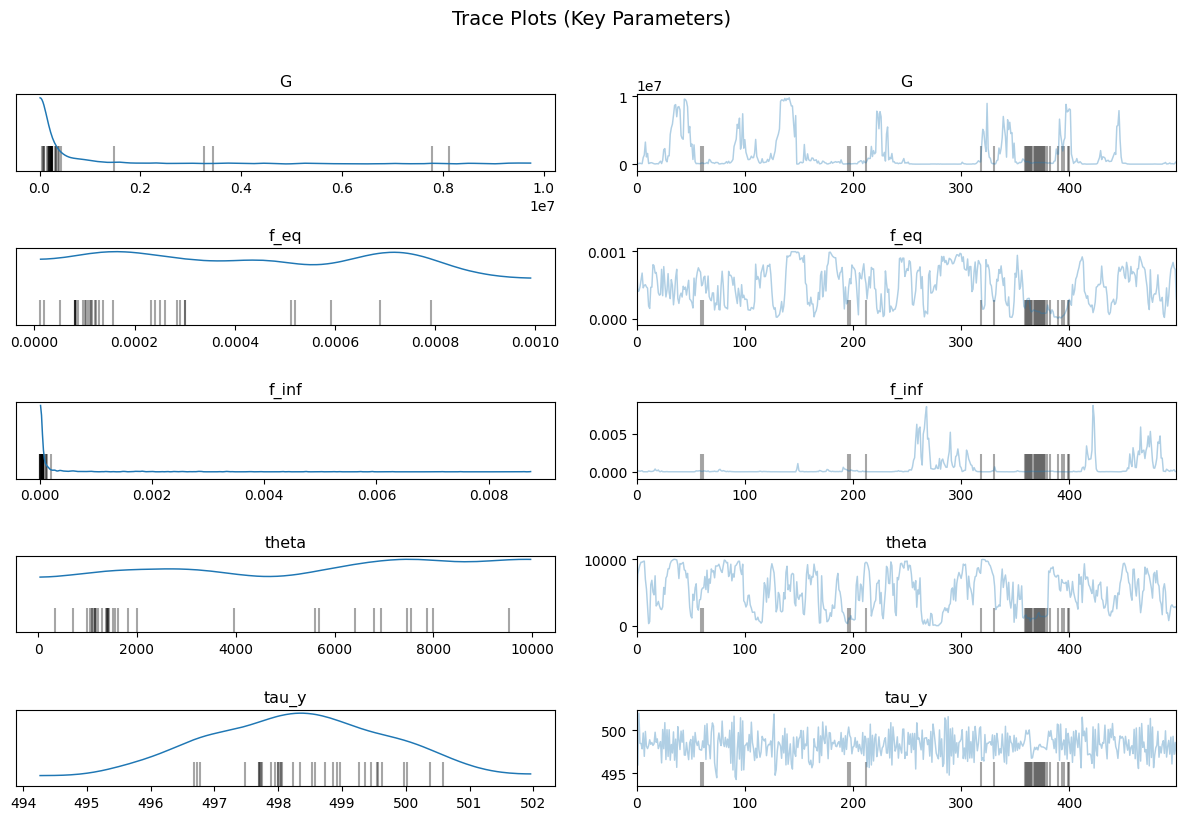

In [12]:
idata = result.to_inference_data()

# Focus on key fluidity parameters for clarity
key_params = ["G", "f_eq", "f_inf", "theta", "tau_y"]

axes = az.plot_trace(idata, var_names=key_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
plt.close('all')

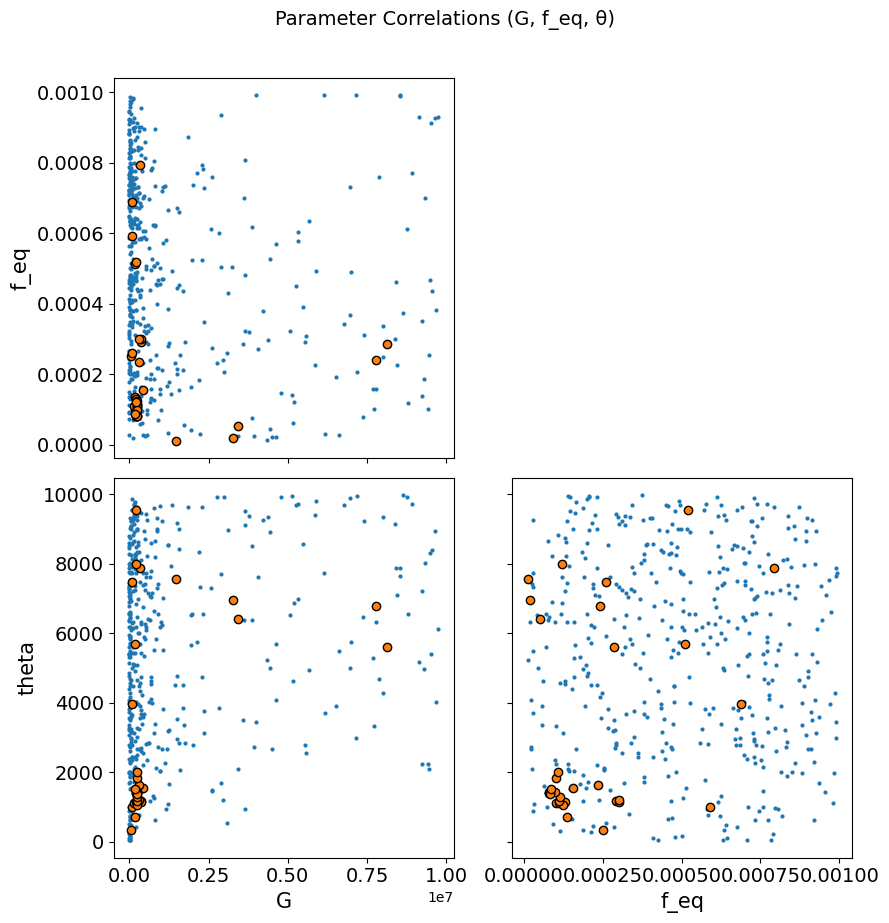

In [13]:
axes = az.plot_pair(
    idata, var_names=["G", "f_eq", "theta"], kind="scatter", divergences=True, figsize=(9, 9)
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations (G, f_eq, θ)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
plt.close('all')

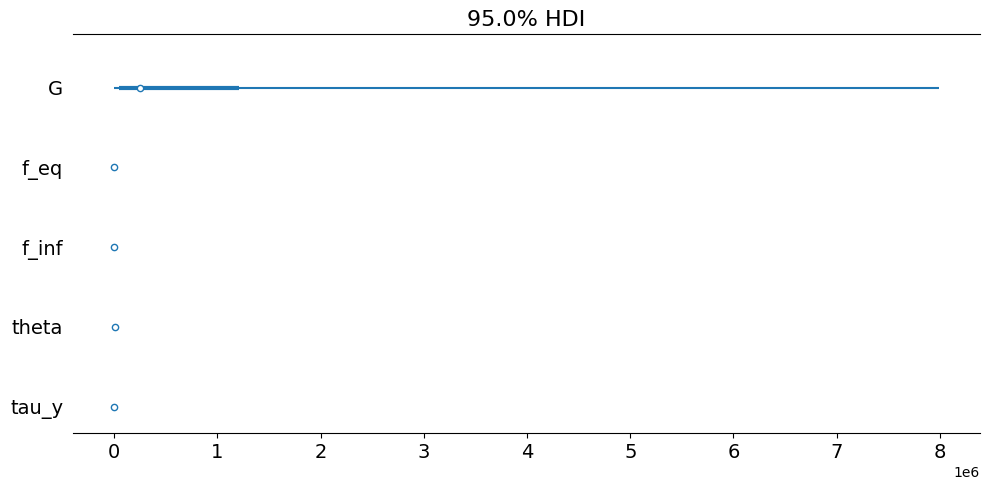

In [14]:
axes = az.plot_forest(
    idata, var_names=key_params, combined=True, hdi_prob=0.95, figsize=(10, 5)
)
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

### 5.4 Posterior Predictive Check

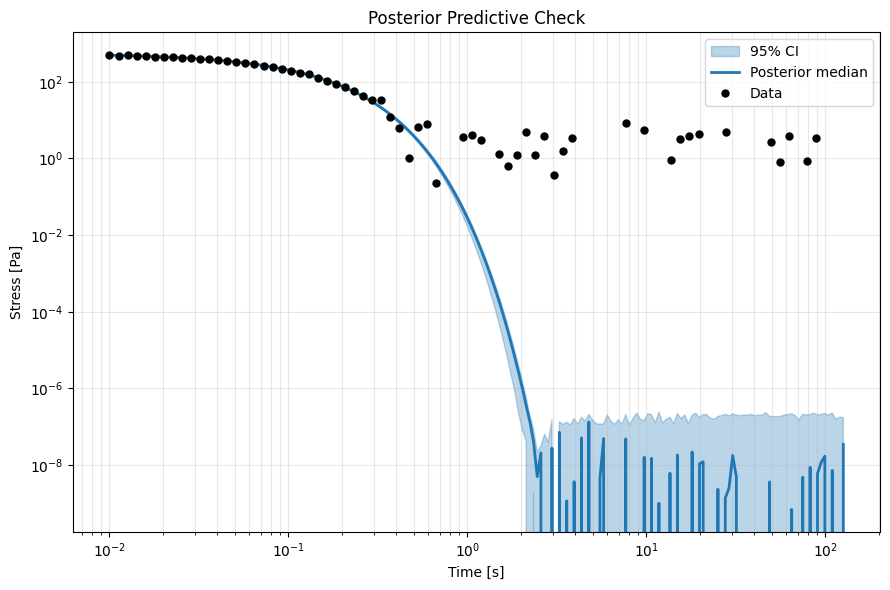

In [15]:
posterior = result.posterior_samples
n_draws = min(200, len(posterior["G"]))

# Predict with posterior draws
pred_samples = []
for i in range(n_draws):
    # Build parameter array matching model_function signature
    params_i = jnp.array(
        [
            posterior["G"][i],
            posterior["tau_y"][i],
            posterior["K"][i],
            posterior["n_flow"][i],
            posterior["f_eq"][i],
            posterior["f_inf"][i],
            posterior["theta"][i],
            posterior["a"][i],
            posterior["n_rejuv"][i],
        ]
    )
    # Note: model_function may need sigma_0 in kwargs
    pred_i = model.model_function(
        jnp.asarray(t_fine), params_i, test_mode="relaxation", sigma_0=stress[0]
    )
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(t_fine, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(t_fine, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(t_data, stress, "ko", markersize=5, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

### 5.5 Parameter Comparison

In [16]:
print_parameter_comparison(model, posterior, param_names=param_names)


Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                        95% CI
----------------------------------------------------------------------
           G     1.878e+05     2.466e+05  [2083, 9.046e+06]
       tau_y         831.4         498.3  [495.5, 500.9]
           K         738.8     5.892e+05  [4.176e+04, 9.529e+05]
      n_flow         1.935         1.093  [0.181, 1.999]
        f_eq     2.998e-08     0.0004703  [2.804e-05, 0.0009506]
       f_inf     0.0001891     3.981e-05  [1.091e-06, 0.004736]
       theta        0.2627          5480  [343, 9715]
           a             1         53.93  [0.7962, 97.57]
     n_rejuv             1        0.7294  [0.03299, 1.889]


## 6. Save Results

In [17]:
save_fluidity_results(
    model, result, model_variant="local", protocol="relaxation", param_names=param_names
)

# Also save fluidity evolution for future reference
output_dir = get_output_dir("local", "relaxation")
fluidity_data = {"time": t_fine.tolist(), "fluidity": fluidity_sim.tolist()}
with open(os.path.join(output_dir, "fluidity_evolution.json"), "w") as f:
    json.dump(fluidity_data, f)
print(f"Fluidity evolution saved to {output_dir}/fluidity_evolution.json")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fluidity/local/relaxation/
  nlsq_params_relaxation.json: 9 parameters
  posterior_relaxation.json: 500 draws
Fluidity evolution saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fluidity/local/relaxation/fluidity_evolution.json


## Key Takeaways

1. **Non-exponential decay**: FluidityLocal predicts σ(t) decay faster than simple exponential due to time-varying fluidity f(t), reflecting thixotropic aging.

2. **Aging mechanism**: After flow stops (γ̇=0), fluidity f(t) decreases from f_inf (high, recent flow) toward f_eq (low, structural recovery). This is the structural aging signature.

3. **Accelerating relaxation**: Lower f → slower stress relaxation rate dσ/dt = -Gσf. The relaxation time τ_eff(t) = 1/(Gf(t)) increases with time, creating stretched exponential behavior.

4. **Contrast with Maxwell**: Standard viscoelastic models show straight lines on semi-log plots (exponential). Fluidity models show curvature due to evolving microstructure.

5. **Parameter identifiability**: Relaxation data primarily constrains G, f_eq, and θ (aging time). Flow parameters (tau_y, K, n) have weak influence but are needed for full model consistency.

**Next Steps:** Explore startup shear (NB 02) for stress overshoot from thixotropic breakdown, or creep (NB 03) for delayed yielding. Both protocols reveal complementary aspects of fluidity dynamics.